# Проект по анализу данных "Кадровая аналитика: Проблема смены работы"

#### Шемчук Григорий, 11-904



## Введение

Проект по анализу данных потенциальных, действующих и бывших сотрудников различных компаний. Когда организация берет человека на стажировку, она хочет понимать, принесет ли он пользу компании в будущем, или например, просто использует курсы и стажировку как базу для наращивания опыта и последующего трудоустройства в другую фирму. Другими словами, задача стоит более детально оценить текучку компании. 

Задачи проекта:
1. Построить инструмент, позволяющий предсказать, покинет ли потенциальный работник компанию по прошествии времени стажировки/более длительного времени
2. Сравнить алгоритмы "Дерево решений" и "Случайный лес" в условиях создания данного инструмента
3. (Дополнительно) Построить web интерфейс для удобного пользования инструментом (не реализовано)
    
С чем работаем:
Данные более 19000 стажеров и абитурьентов, в которых есть как личностные поля (например, пол, город, уровень образования), так и данные самих компаний, в которых проводилась стажировка (например, количество сотрудников компании, тип компании и так далее)

## Смотрим данные

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Есть два набора - aug_train и aug_test
# Но в aug_test нет проверочного поля target
# Поэтому пользы он для нас не несет, будем использовать только aug_train (делим в пункте алгоритмов)
# 80% - на обучение, 20% - на тест

df = pd.read_csv('./data/aug_train.csv')

In [3]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
# инфа
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
# статистика по данным
df.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


## Смотрим, сколько хочет уйти

In [6]:
print((df['target'].value_counts() / len(df))*100)

0.0    75.065247
1.0    24.934753
Name: target, dtype: float64


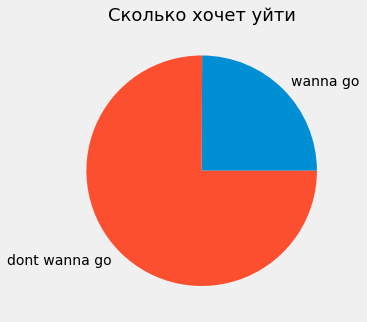

In [57]:
sizes = list(df['target'].value_counts().sort_values().values)
labels = ['wanna go', 'dont wanna go']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels)
plt.title('Сколько хочет уйти', fontsize=18)
plt.tight_layout()

plt.show()

## Еще немного визуализации..

Text(0, 0.5, 'Кол-о')

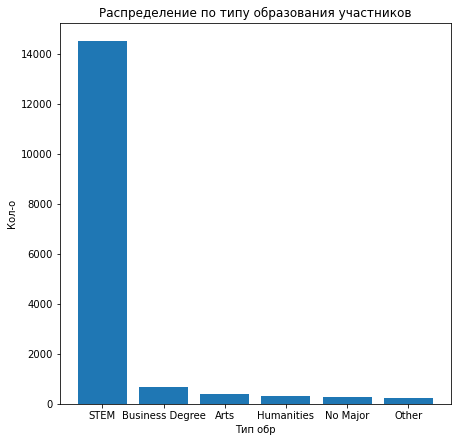

In [8]:
# Распределение по типу образования участников - 
# бОльшая часть получила техническое образование
columns = df["major_discipline"].unique()
columns = [x for x in columns if str(x) != 'nan']
sizes = list(df["major_discipline"].value_counts().values)

plt.figure(figsize=(7,7))
plt.bar(columns, sizes)

plt.title("Распределение по типу образования участников")
plt.xlabel("Тип обр")
plt.ylabel("Кол-о")

Text(0, 0.5, 'Кол-о')

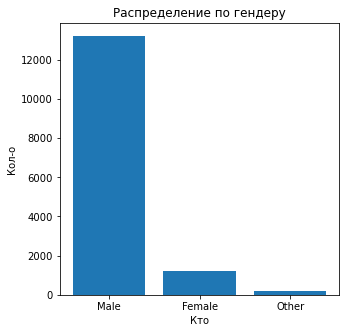

In [9]:
# Посмотрим распределение участников по гендеру
columns = df["gender"].unique()
columns = [x for x in columns if str(x) != 'nan']
sizes = list(df["gender"].value_counts().values)

plt.figure(figsize=(5,5))
plt.bar(columns, sizes)

plt.title("Распределение по гендеру")
plt.xlabel("Кто")
plt.ylabel("Кол-о")

Text(0, 0.5, 'Кол-о')

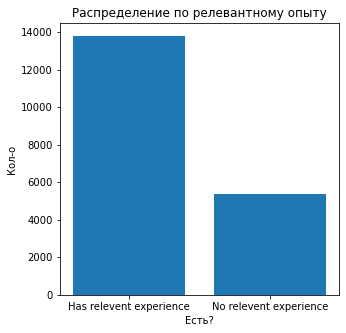

In [10]:
# Посмотрим распределение по релевантному опыту -
# как выясняется, большинство все же имеет 
columns = df["relevent_experience"].unique()
columns = [x for x in columns if str(x) != 'nan']
sizes = list(df["relevent_experience"].value_counts().values)

plt.figure(figsize=(5,5))
plt.bar(columns, sizes)

plt.title("Распределение по релевантному опыту")
plt.xlabel("Есть?")
plt.ylabel("Кол-о")

Text(0.5, 1.0, 'Завершенные учебные часы')

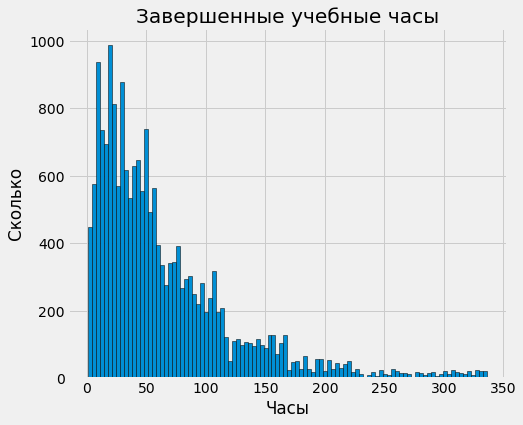

In [11]:
# Смотрим распределение по завершенным учебным часам - большинство заканчивают стажировку/тренинги на ~50 часах

plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,6))
plt.hist(df['training_hours'].dropna(), bins = 100, edgecolor = 'k')

plt.xlabel('Часы') 
plt.ylabel('Сколько')
plt.title('Завершенные учебные часы')

## Чистим данные

In [12]:
# сколько есть пустоты
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [13]:
# Заменим nan на 0, таким образом, в перечеслениях (например, gender) они будут попадать в категорию Other
# А в численных полях (например, experience), будут просто нулями

for column in ['gender','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type','last_new_job']:
    df[column].fillna(0, inplace = True)
    
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [14]:
# Есть дубли? нет

df.duplicated().sum()

0

In [15]:
# Ну и на последок удалим абсолютно ненужное поле с айдишником

df = df.drop(columns = 'enrollee_id')

## Готовим данные к алгоритмам

In [16]:
# Кодируем гендер: 0 - женщина, 1 - мужчина, 2 - не определен..
df["gender"] = [ 
    0 if gender == "Female"
    else 1 if gender == "Male"
    else 2 for gender in df["gender"]]

In [17]:
# Заменяем "релевантный" опыт на Boolean
df = df.replace({'relevent_experience': { 'Has relevent experience': True, 'No relevent experience': False }})

In [18]:
# Кодируем "образование": 0 - аналог Бакалавриата, 1 - аналог Магистратуры, 2 - "Кандидат наук"   
df["education_level"] = [ 
    0 if education_level  == "Graduate"
    else 1 if education_level == "Masters"
    else 2 for education_level in df["education_level"]]

In [19]:
# Кодируем "поступление на курсы компании": 0 - не поступил, 1 - полный курс, 2 - другое
df["enrolled_university"] = [ 
    0 if enrolled_university  == "no_enrollment"
    else 1 if enrolled_university == "Full time course"
    else 2 for enrolled_university in df["enrolled_university"]]

In [20]:
# переводим города из строк в цифры
df['city'] = df['city'].str.replace('city_','')
df["city"] = df["city"].apply(pd.to_numeric, downcast='integer')
df['city'].value_counts()

103    4355
21     2702
16     1533
114    1336
160     845
       ... 
129       3
111       3
121       3
140       1
171       1
Name: city, Length: 123, dtype: int64

In [21]:
#major_discipline 
df["major_discipline"].value_counts()

STEM               14492
0                   2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [22]:
# Кодируем тип образования: 0 - техническое, 1 - общественные науки, 2 - бизнес, 3 - художество, 4 - нет, 5 - прочее 
df["major_discipline"] = [ 
    0 if i == "STEM"
    else 1 if i == "Humanities"
    else 2 if i == "Business Degree"
    else 3 if i == "Arts" 
    else 4 if i == "No Major" 
    else 5 for i in df["major_discipline"]]

In [23]:
# Переводим опыт в цифру
df["experience"] = df["experience"].str.replace('>', '')
df["experience"] = df["experience"].str.replace('<', '')
df["experience"] = df["experience"].apply(pd.to_numeric, downcast='float')
df['experience'] = df['experience'].fillna(0)
df['experience'].value_counts()

20.0    3434
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
1.0     1071
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
14.0     586
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
0.0       65
Name: experience, dtype: int64

In [24]:
# Переводим "когда последний раз менял работу" в цифру
# never - 0
df["last_new_job"] = df["last_new_job"].str.replace('>', '')
df["last_new_job"] = df["last_new_job"].str.replace('<', '')
df["last_new_job"] = df["last_new_job"].str.replace('never', '0')
df["last_new_job"] = df["last_new_job"].apply(pd.to_numeric, downcast='float')
df['last_new_job'] = df['last_new_job'].fillna(0)
df['last_new_job'].value_counts()

1.0    8040
4.0    4319
2.0    2900
0.0    2875
3.0    1024
Name: last_new_job, dtype: int64

In [25]:
# Переводим "размер компании", берем за значение минимально возможное кол-о сотрудников
df["company_size"] = df["company_size"].str.split("-").str.get(0)
df["company_size"] = df["company_size"].str.split("/").str.get(0)
df["company_size"] = df["company_size"].str.replace("\+", '')
df["company_size"] = df["company_size"].str.replace("<", '')
df["company_size"] = df["company_size"].str.replace(">", '')
df["company_size"] = df["company_size"].apply(pd.to_numeric, downcast='float')
df['company_size'] = df['company_size'].fillna(0)
df['company_size'].value_counts()

C:\Users\schem\AppData\Local\Temp/ipykernel_8224/192077953.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["company_size"] = df["company_size"].str.replace("\+", '')


0.0        5938
50.0       3083
10.0       2779
100.0      2571
10000.0    2019
1000.0     1328
500.0       877
5000.0      563
Name: company_size, dtype: int64

In [26]:
# Кодируем тип компании: 0 - стандарт, 1 - "старый" стартап, 2 - гос. орг., 3 - новый стартап, 4 - NGO, 5 - остальное 
df["company_type"] = [ 
    0 if i == "Pvt Ltd"
    else 1 if i == "Funded Startup"
    else 2 if i == "Public Sector"
    else 3 if i == "Early Stage Startup" 
    else 4 if i == "NGO" 
    else 5 for i in df["company_type"]]

# Применение алгоритмов

In [27]:
# Сначала подготовим данные для обучения и для теста

from sklearn.model_selection import train_test_split


data = df.drop(columns = 'target')
answers = df['target']

data_train, data_test, answers_train, answers_test = train_test_split(data, answers, test_size = 0.2)

## a) Простое дерево решений

In [36]:
# Для начала просто посмотрим стандартное дерево решений

from sklearn.tree import DecisionTreeClassifier


# Описание параметров: 
# criterion - тип функции для оценки качества разбиения, использую критерий Джини - вероятностный метод  
# max_depth - максимально возможная глубина дерева
# random_state - Контроль случайности оценки
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state = 1)
tree.fit(data_train, answers_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [37]:
# Применяем "Матрицу ошибок" для просмотра результатов (и, конечно, вычислим Accuracy)

from sklearn.metrics import confusion_matrix

answers_predicted = tree.predict(data_test)

matrix = confusion_matrix(answers_test, answers_predicted, labels=[1,0])
print('Confusion matrix : \n', matrix)

accur = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[1][1] + matrix[0][1] + matrix[1][0])
print('\nAccuracy = ', accur)

Confusion matrix : 
 [[ 552  416]
 [ 411 2453]]

Accuracy =  0.7841858037578288


## b) Случайный лес

In [53]:
# Теперь, рассмотрим решение на "Случайном лесу"

from sklearn.ensemble import RandomForestClassifier


# Описание параметров: 
# criterion - тип функции для оценки качества разбиения, использую критерий Джини - вероятностный метод  
# n_estimators - количество деревьев в структуре
# max_depth - максимально возможная глубина
forest = RandomForestClassifier(criterion = "gini", max_depth = 32, n_estimators = 1250)

forest.fit(data_train, answers_train)

RandomForestClassifier(max_depth=32, n_estimators=250)

In [54]:
# Снова применяем "Матрицу ошибок" и вычисляем Accuracy

answers_predicted = forest.predict(data_test)

matrix = confusion_matrix(answers_test, answers_predicted, labels=[1,0])
print('Confusion matrix : \n', matrix)

accur = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[1][1] + matrix[0][1] + matrix[1][0])
print('\nAccuracy = ', accur)

Confusion matrix : 
 [[ 487  481]
 [ 359 2505]]

Accuracy =  0.7807933194154488


## Вывод

Для достаточно простой задачи классификации работников по критерию "желания уйти с работы", нет особой разницы между использованием алгоритма дерева решений и случайного леса. 

Перечислим основные плюсы и минусы моделей:

Дерево решений:
* +) Легко визуализировать процесс принятия решения - может помочь выработать стратегию HR работникам / руководителям, например, для более бдительного внимания за сотрудниками/стажерами, у которых наблюдаются признаки "желания уйти с работы"
* +) Простой и легкий, требует гораздо меньшего кол-а мощностей по сравнению с другой моделью
* -) Может страдать от переобучения, которое, однако, в условиях нашей задачи, не грозит
    
Случайный лес:
* +) Высокоточный и надежный метод, поскольку в процессе прогнозирования участвует множество деревьев решений
* +) Не страдает проблемой переобучения
* -) Очень медленный, особенно по сравнению с отдельным Деревом решений
* -) Сложен в интерпритации
    
Таким образом, для нашей задачи больше подходит алгоритм "Дерево решений", так как при сравнительных результатах, он требует меньших мощностей, а еще с помощью него можно получить понятную интерпретацию процесса принятия решения 